In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from os import listdir
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from mlxtend.evaluate import scoring
from matplotlib.colors import ListedColormap

In [70]:
CMAP2 = ListedColormap(['C0', 'C1'])
CMAP3 = ListedColormap(['C0', 'C1', 'C2'])

MARKERS = ['o', 's', '^']

In [3]:
def importar_dados(arquivo):
    df = pd.read_csv(arquivo, sep=' ', names=['x1', 'x2', 'classe'])
    
    X = df[['x1', 'x2']].values
    y = df['classe'].values
    
    return X, y

In [4]:
def exibir_amostras(X, y, 
                    titulo=None, 
                    salvar=False, 
                    figsize=(10, 8), 
                    legend_fontsize=20, 
                    title_fontsize=24, 
                    labels_fontsize=24, 
                    ticks_fontsize=16):
    
    classes = list(set([classe for classe in y]))
    n_classes = len(classes)
    
    plt.figure(figsize=figsize)
    
    for classe in classes:
        plt.scatter(X[y == classe][:, 0], X[y == classe][:, 1], s=100, label='Classe ' + str(classe))
    
    plt.legend(fontsize=legend_fontsize)
    plt.grid(True, linestyle='-', alpha=0.5)
    
#     plt.title(str(titulo), fontsize=title_fontsize)
    plt.xlabel(r'$x_{1}$', fontsize=labels_fontsize)
    plt.ylabel(r'$x_{2}$', fontsize=labels_fontsize)
    plt.xticks(fontsize=ticks_fontsize)
    plt.yticks(fontsize=ticks_fontsize)
    
    if salvar:
        plt.savefig(titulo + '.pdf', format='pdf', dpi=300, transparent=True, bbox_inches='tight')
    
    plt.show()

In [5]:
class AnaliseDiscriminante:
    def __init__ (self, tipo='LDA'):
        self.tipo = tipo
        
    def treinar (self, X, y):
        self.classes = list(set(y))
        self.n_classes = len(self.classes)
        self.n_amostras = len(X)
        self.n_amostras_classe = [len(X[y == c]) for c in self.classes]
        self.probs = [n / self.n_amostras for n in self.n_amostras_classe]
        self.mu = np.mean(X, axis=0)
        self.mu_classe = [np.mean(X[y == c], axis=0) for c in self.classes]
        
        if self.tipo == 'LDA':
            self.sigma = np.cov(X.T)
            self.sigma_inv = np.linalg.inv(self.sigma)
            
        elif self.tipo == 'QDA':
            self.sigma = np.array([np.cov(X[y == c].T) for c in self.classes])
            self.sigma_inv = np.array([np.linalg.inv(matriz) for matriz in self.sigma])
        
        else:
            print("O tipo deve ser 'LDA' ou 'QDA'. Escolha um dos dois!")
        
    def __delta_LDA(self, X, mu, P):
        return (np.matrix(X) * np.matrix(self.sigma_inv).T * np.matrix(mu).T - 0.5 * np.matrix(mu) * np.matrix(self.sigma_inv) * np.matrix(mu).T + np.log(P)).A1[0]
    
    def __delta_QDA(self, X, mu, sigma, sigma_inv, P):
        return (-0.5 * np.log(np.linalg.det(sigma)) - 0.5 * np.matrix(X - mu) * np.matrix(sigma_inv).T * np.matrix(X - mu).T + np.log(P)).A1[0]
        
    def classificar (self, X):
        if self.tipo == 'LDA':
            self.deltas = np.array([[self.__delta_LDA(amostra, self.mu_classe[i], self.probs[i]) for i in range(len(self.classes))] for amostra in X])
        
        elif self.tipo == 'QDA':
            self.deltas = np.array([[self.__delta_QDA(amostra, self.mu_classe[i], self.sigma[i], self.sigma_inv[i], self.probs[i]) for i in range(len(self.classes))] for amostra in X])
        
        else:
            print("O tipo deve ser 'LDA' ou 'QDA'. Escolha um dos dois!")
        
        return np.array([np.argmax(amostra)+1 for amostra in self.deltas])

In [6]:
def holdout(X, y, teste_parcela=0.30, aleatorio=True, semente=None):
    n_amostras = len(X)
    n_amostras_teste = int(teste_parcela * n_amostras)
    n_amostras_treino = n_amostras - n_amostras_teste

    if aleatorio:
        if semente == None:
            semente = random.randint(0, 1000)
        random.seed(semente)
        teste_idx = np.array(sorted(random.sample(range(n_amostras), n_amostras_teste)))

    else:
        teste_idx = np.arange(n_amostras - n_amostras_teste - 1, n_amostras)

    treino_idx = np.array(list(set(np.arange(n_amostras)) - set(teste_idx)))
    X_teste = np.array([X[idx] for idx in teste_idx])
    y_teste = np.array([y[idx] for idx in teste_idx])
    X_treino = np.array([X[idx] for idx in treino_idx])
    y_treino = np.array([y[idx] for idx in treino_idx])
    
    return X_treino, y_treino, X_teste, y_teste

In [7]:
def avaliar_desempenho(y_verdadeiro, y_obtido):
    return scoring(y_verdadeiro, y_obtido, metric='accuracy', )

### Dataset 1

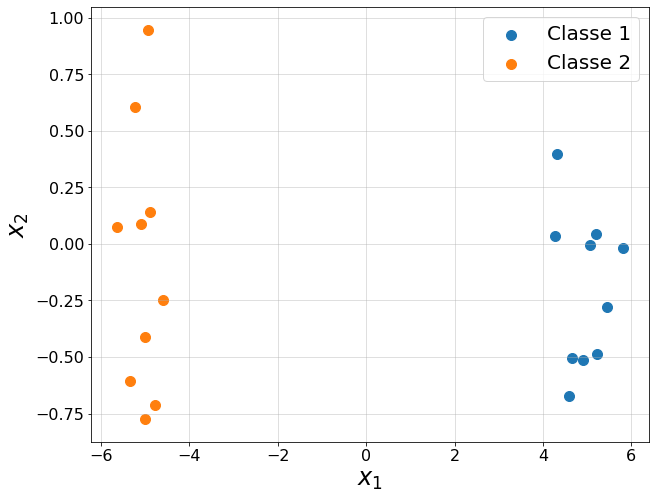

In [8]:
X1, y1 = importar_dados('datasets/dataset1.txt')
exibir_amostras(X=X1, y=y1)

In [9]:
# Bootstrap
n_repeticoes = 10

LDA_desempenho = []
QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X1, y=y1, teste_parcela=0.30, aleatorio=True, semente=None)
    
    # LDA - Próprio
    LDA = AnaliseDiscriminante(tipo='LDA')
    LDA.treinar(X=X_treino, y=y_treino)
    LDA_y_predito = LDA.classificar(X=X_teste)
    LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=LDA_y_predito))
    
    # QDA - Próprio
    QDA = AnaliseDiscriminante(tipo='QDA')
    QDA.treinar(X=X_treino, y=y_treino)
    QDA_y_predito = QDA.classificar(X=X_teste)
    QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=QDA_y_predito))

LDA_desempenho = np.array(LDA_desempenho)
LDA_desempenho_media = np.mean(LDA_desempenho)
LDA_desempenho_std = np.std(LDA_desempenho)

QDA_desempenho = np.array(QDA_desempenho)
QDA_desempenho_media = np.mean(QDA_desempenho)
QDA_desempenho_std = np.std(QDA_desempenho)


print('DATASET 1')
print('------ Acurácias -----')
print('LDA: {0:3.4f}'.format(LDA_desempenho_media))
print('QDA: {0:3.4f}'.format(QDA_desempenho_media))

DATASET 1
------ Acurácias -----
LDA: 1.0000
QDA: 1.0000


In [10]:
x_min1, x_max1 = X1[:, 0].min() - 2, X1[:, 0].max() + 2
y_min1, y_max1 = X1[:, 1].min() - 2, X1[:, 1].max() + 2
h = 0.01
xx1, yy1 = np.meshgrid(np.arange(x_min1, x_max1, h),
                     np.arange(y_min1, y_max1, h))

Z1_LDA = LDA.classificar(np.c_[xx1.ravel(), yy1.ravel()])
Z1_QDA = QDA.classificar(np.c_[xx1.ravel(), yy1.ravel()])

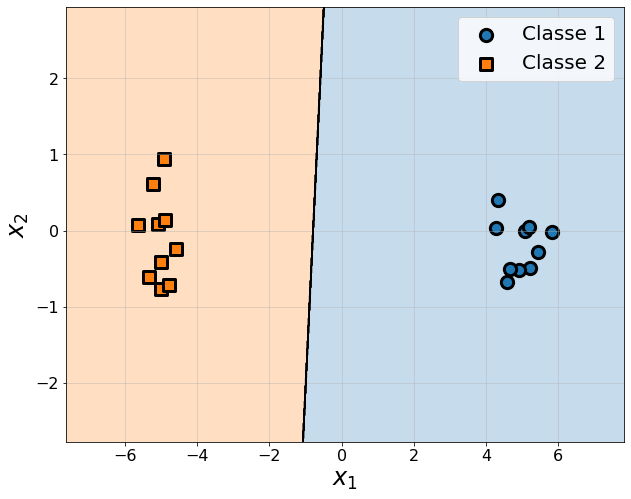

In [48]:
classes = list(set([classe for classe in y1]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

Z1_LDA = Z1_LDA.reshape(xx1.shape)
plt.contourf(xx1, yy1, Z1_LDA, cmap=CMAP2, alpha=0.25)
plt.contour(xx1, yy1, Z1_LDA, colors='black')

# Z1_QDA = Z1_QDA.reshape(xx1.shape)
# plt.contourf(xx1, yy1, Z1_QDA, cmap=CMAP2, alpha=0.75)
# plt.contour(xx1, yy1, Z1_QDA, colors='black')

for classe in classes:
    plt.scatter(X1[y1 == classe][:, 0], 
                X1[y1 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150, 
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

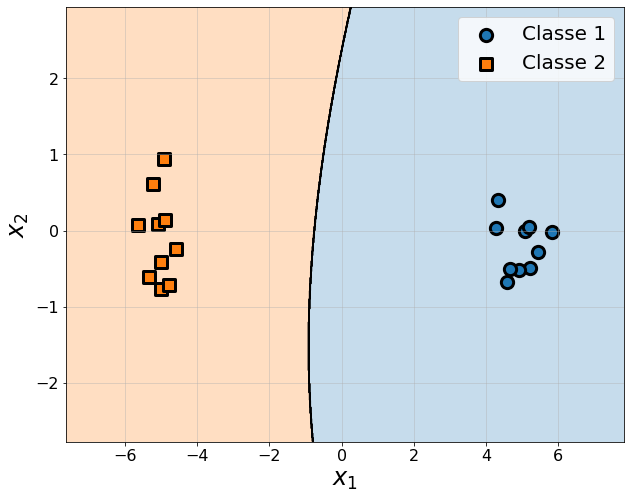

In [47]:
classes = list(set([classe for classe in y1]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

# Z1_LDA = Z1_LDA.reshape(xx1.shape)
# plt.contourf(xx1, yy1, Z1_LDA, cmap=CMAP2, alpha=0.25)
# plt.contour(xx1, yy1, Z1_LDA, colors='black')

Z1_QDA = Z1_QDA.reshape(xx1.shape)
plt.contourf(xx1, yy1, Z1_QDA, cmap=CMAP2, alpha=0.25)
plt.contour(xx1, yy1, Z1_QDA, colors='black')

for classe in classes:
    plt.scatter(X1[y1 == classe][:, 0], 
                X1[y1 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150, 
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

**Classificador mais adequado**: para o Dataset 1, o LDA já é suficiente para atuar bem, mas nada impede que seja escolhido o QDA.

### Dataset 2

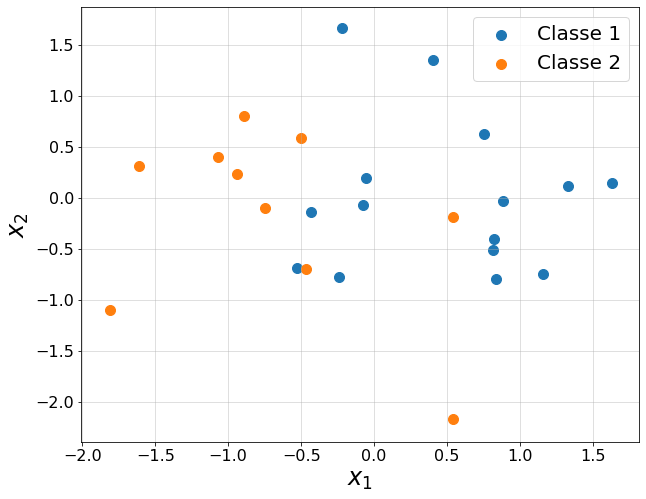

In [13]:
X2, y2 = importar_dados('datasets/dataset2.txt')
exibir_amostras(X=X2, y=y2)

In [14]:
# Bootstrap
n_repeticoes = 10

LDA_desempenho = []
QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X2, y=y2, teste_parcela=0.30, aleatorio=True, semente=None)
    
    # LDA - Próprio
    LDA = AnaliseDiscriminante(tipo='LDA')
    LDA.treinar(X=X_treino, y=y_treino)
    LDA_y_predito = LDA.classificar(X=X_teste)
    LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=LDA_y_predito))
    
    # QDA - Próprio
    QDA = AnaliseDiscriminante(tipo='QDA')
    QDA.treinar(X=X_treino, y=y_treino)
    QDA_y_predito = QDA.classificar(X=X_teste)
    QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=QDA_y_predito))

LDA_desempenho = np.array(LDA_desempenho)
LDA_desempenho_media = np.mean(LDA_desempenho)
LDA_desempenho_std = np.std(LDA_desempenho)

QDA_desempenho = np.array(QDA_desempenho)
QDA_desempenho_media = np.mean(QDA_desempenho)
QDA_desempenho_std = np.std(QDA_desempenho)


print('DATASET 1')
print('------ Acurácias -----')
print('LDA: {0:3.4f}'.format(LDA_desempenho_media))
print('QDA: {0:3.4f}'.format(QDA_desempenho_media))

DATASET 1
------ Acurácias -----
LDA: 0.7714
QDA: 0.6714


In [15]:
x_min2, x_max2 = X2[:, 0].min() - 2, X2[:, 0].max() + 2
y_min2, y_max2 = X2[:, 1].min() - 2, X2[:, 1].max() + 2
h = 0.01
xx2, yy2 = np.meshgrid(np.arange(x_min2, x_max2, h),
                     np.arange(y_min2, y_max2, h))

Z2_LDA = LDA.classificar(np.c_[xx2.ravel(), yy2.ravel()])
Z2_QDA = QDA.classificar(np.c_[xx2.ravel(), yy2.ravel()])

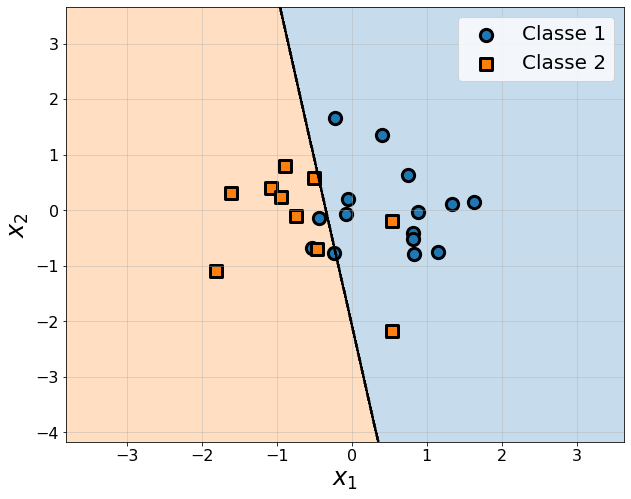

In [46]:
classes = list(set([classe for classe in y2]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

Z2_LDA = Z2_LDA.reshape(xx2.shape)
plt.contourf(xx2, yy2, Z2_LDA, cmap=CMAP2, alpha=0.25)
plt.contour(xx2, yy2, Z2_LDA, colors='black')

# Z2_QDA = Z2_QDA.reshape(xx2.shape)
# plt.contourf(xx2, yy2, Z2_QDA, cmap=CMAP2, alpha=0.25)
# plt.contour(xx2, yy2, Z2_QDA, colors='black')

for classe in classes:
    plt.scatter(X2[y2 == classe][:, 0], 
                X2[y2 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150, 
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

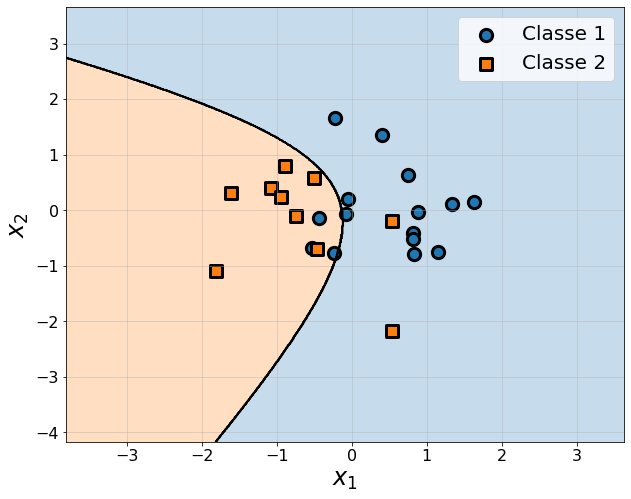

In [45]:
classes = list(set([classe for classe in y2]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

# Z2_LDA = Z2_LDA.reshape(xx2.shape)
# plt.contourf(xx2, yy2, Z2_LDA, cmap=CMAP2, alpha=0.25)
# plt.contour(xx2, yy2, Z2_LDA, colors='black')

Z2_QDA = Z2_QDA.reshape(xx2.shape)
plt.contourf(xx2, yy2, Z2_QDA, cmap=CMAP2, alpha=0.25)
plt.contour(xx2, yy2, Z2_QDA, colors='black')

for classe in classes:
    plt.scatter(X2[y2 == classe][:, 0], 
                X2[y2 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150,  
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

**Classificador mais adequado**: aqui não parece ser possível zerar a taxa de erros, mas é possível observar que o LDA satisfaz a classificação com uma taxa de erros relativamente baixa.

### Dataset 3

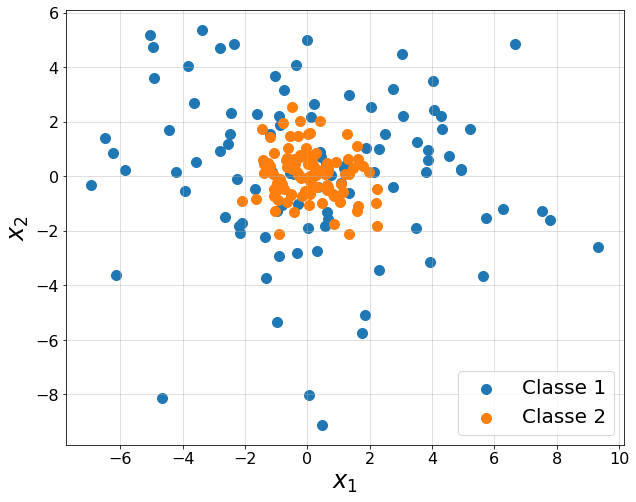

In [18]:
X3, y3 = importar_dados('datasets/dataset3.txt')
exibir_amostras(X=X3, y=y3)

In [19]:
# Bootstrap
n_repeticoes = 10

LDA_desempenho = []
QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X3, y=y3, teste_parcela=0.30, aleatorio=True, semente=None)
    
    # LDA - Próprio
    LDA = AnaliseDiscriminante(tipo='LDA')
    LDA.treinar(X=X_treino, y=y_treino)
    LDA_y_predito = LDA.classificar(X=X_teste)
    LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=LDA_y_predito))
    
    # QDA - Próprio
    QDA = AnaliseDiscriminante(tipo='QDA')
    QDA.treinar(X=X_treino, y=y_treino)
    QDA_y_predito = QDA.classificar(X=X_teste)
    QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=QDA_y_predito))

LDA_desempenho = np.array(LDA_desempenho)
LDA_desempenho_media = np.mean(LDA_desempenho)
LDA_desempenho_std = np.std(LDA_desempenho)

QDA_desempenho = np.array(QDA_desempenho)
QDA_desempenho_media = np.mean(QDA_desempenho)
QDA_desempenho_std = np.std(QDA_desempenho)


print('DATASET 1')
print('------ Acurácias -----')
print('LDA: {0:3.4f}'.format(LDA_desempenho_media))
print('QDA: {0:3.4f}'.format(QDA_desempenho_media))

DATASET 1
------ Acurácias -----
LDA: 0.4717
QDA: 0.8233


In [20]:
x_min3, x_max3 = X3[:, 0].min() - 2, X3[:, 0].max() + 2
y_min3, y_max3 = X3[:, 1].min() - 2, X3[:, 1].max() + 2
h = 0.01
xx3, yy3 = np.meshgrid(np.arange(x_min3, x_max3, h),
                     np.arange(y_min3, y_max3, h))

Z3_LDA = LDA.classificar(np.c_[xx3.ravel(), yy3.ravel()])
Z3_QDA = QDA.classificar(np.c_[xx3.ravel(), yy3.ravel()])

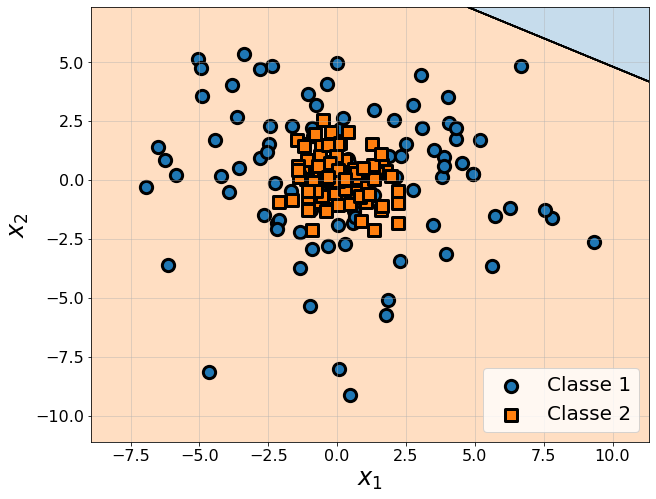

In [44]:
classes = list(set([classe for classe in y3]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

Z3_LDA = Z3_LDA.reshape(xx3.shape)
plt.contourf(xx3, yy3, Z3_LDA, cmap=CMAP2, alpha=0.25)
plt.contour(xx3, yy3, Z3_LDA, colors='black')

# Z3_QDA = Z3_QDA.reshape(xx3.shape)
# plt.contourf(xx3, yy3, Z3_QDA, cmap=CMAP2, alpha=0.25)
# plt.contour(xx3, yy3, Z3_QDA, colors='black')

for classe in classes:
    plt.scatter(X3[y3 == classe][:, 0], 
                X3[y3 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150,  
                linewidth=3,
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

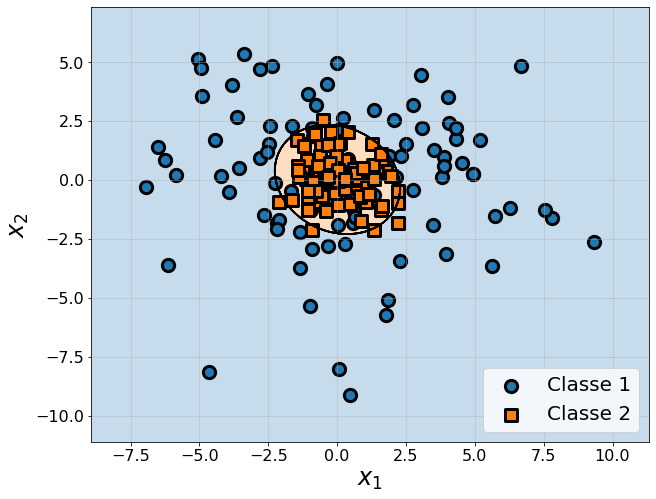

In [43]:
classes = list(set([classe for classe in y3]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

# Z3_LDA = Z3_LDA.reshape(xx3.shape)
# plt.contourf(xx3, yy3, Z3_LDA, cmap=CMAP2, alpha=0.25)
# plt.contour(xx3, yy3, Z3_LDA, colors='black')

Z3_QDA = Z3_QDA.reshape(xx3.shape)
plt.contourf(xx3, yy3, Z3_QDA, cmap=CMAP2, alpha=0.25)
plt.contour(xx3, yy3, Z3_QDA, colors='black')

for classe in classes:
    plt.scatter(X3[y3 == classe][:, 0], 
                X3[y3 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150, 
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

**Classificador mais adequado**: neste dataset é bastante evidente que há uma intensa sobreposição entre os dados, e o QDA é bem mais conveniente.

### Dataset 4

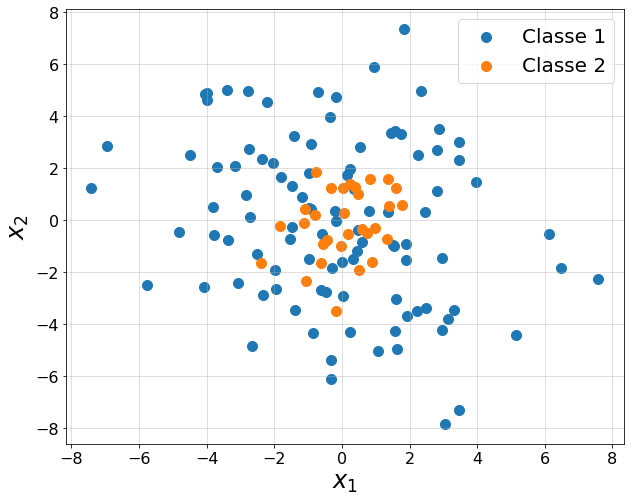

In [23]:
X4, y4 = importar_dados('datasets/dataset4.txt')
exibir_amostras(X=X4, y=y4)

In [60]:
# Bootstrap
n_repeticoes = 10

LDA_desempenho = []
QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X4, y=y4, teste_parcela=0.30, aleatorio=True, semente=None)
    
    # LDA - Próprio
    LDA = AnaliseDiscriminante(tipo='LDA')
    LDA.treinar(X=X_treino, y=y_treino)
    LDA_y_predito = LDA.classificar(X=X_teste)
    LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=LDA_y_predito))
    
    # QDA - Próprio
    QDA = AnaliseDiscriminante(tipo='QDA')
    QDA.treinar(X=X_treino, y=y_treino)
    QDA_y_predito = QDA.classificar(X=X_teste)
    QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=QDA_y_predito))

LDA_desempenho = np.array(LDA_desempenho)
LDA_desempenho_media = np.mean(LDA_desempenho)
LDA_desempenho_std = np.std(LDA_desempenho)

QDA_desempenho = np.array(QDA_desempenho)
QDA_desempenho_media = np.mean(QDA_desempenho)
QDA_desempenho_std = np.std(QDA_desempenho)


print('DATASET 1')
print('------ Acurácias -----')
print('LDA: {0:3.4f}'.format(LDA_desempenho_media))
print('QDA: {0:3.4f}'.format(QDA_desempenho_media))

DATASET 1
------ Acurácias -----
LDA: 0.7769
QDA: 0.7795


In [65]:
x_min4, x_max4 = X4[:, 0].min() - 2, X4[:, 0].max() + 2
y_min4, y_max4 = X4[:, 1].min() - 2, X4[:, 1].max() + 2
h = 0.01
xx4, yy4 = np.meshgrid(np.arange(x_min4, x_max4, h),
                     np.arange(y_min4, y_max4, h))

Z4_LDA = LDA.classificar(np.c_[xx4.ravel(), yy4.ravel()])
Z4_QDA = QDA.classificar(np.c_[xx4.ravel(), yy4.ravel()])

C:\Users\Tito\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: No contour levels were found within the data range.
  


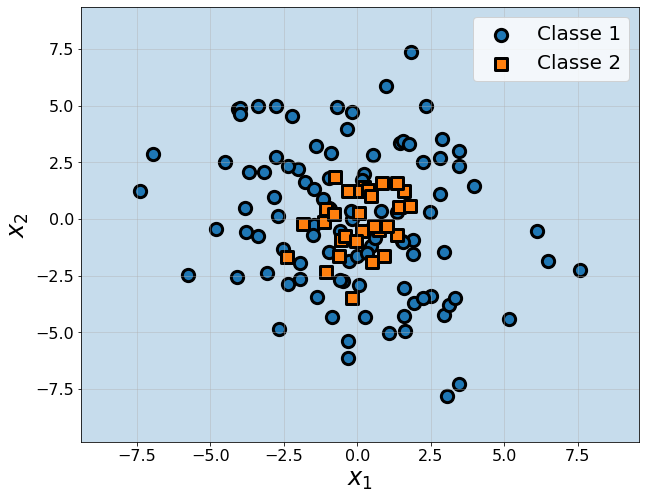

In [66]:
classes = list(set([classe for classe in y4]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

Z4_LDA = Z4_LDA.reshape(xx4.shape)
plt.contourf(xx4, yy4, Z4_LDA, cmap=CMAP2, alpha=0.25)
plt.contour(xx4, yy4, Z4_LDA, colors='black')

# Z4_QDA = Z4_QDA.reshape(xx4.shape)
# plt.contourf(xx4, yy4, Z4_QDA, cmap='Greens', alpha=0.25)
# plt.contour(xx4, yy4, Z4_QDA, colors='black')

for classe in classes:
    plt.scatter(X4[y4 == classe][:, 0], 
                X4[y4 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150, 
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

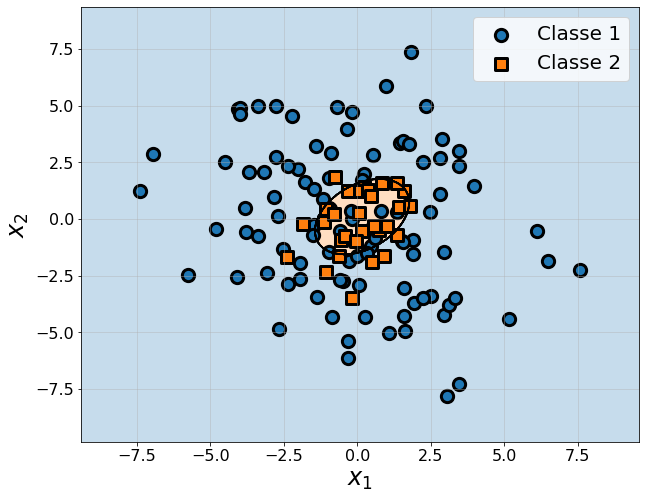

In [67]:
classes = list(set([classe for classe in y4]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

# Z4_LDA = Z4_LDA.reshape(xx4.shape)
# plt.contourf(xx4, yy4, Z4_LDA, cmap='Greens', alpha=0.25)
# plt.contour(xx4, yy4, Z4_LDA, colors='black')

Z4_QDA = Z4_QDA.reshape(xx4.shape)
plt.contourf(xx4, yy4, Z4_QDA, cmap=CMAP2, alpha=0.25)
plt.contour(xx4, yy4, Z4_QDA, colors='black')

for classe in classes:
    plt.scatter(X4[y4 == classe][:, 0], 
                X4[y4 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150, 
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

**Classificador mais adequado**: aqui também á uma considerável sobreposição das amostras, mas é menos agressiva do que o observado no dataset anterior. Embora não aparente, LDA e QDA exibirão resultados bastante próximos.

### Dataset 5

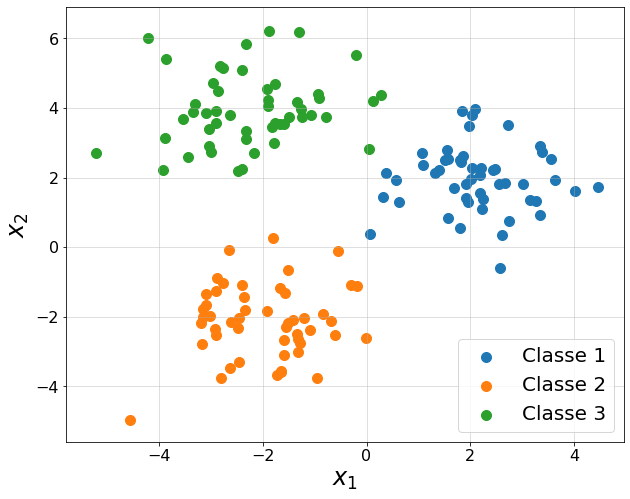

In [28]:
X5, y5 = importar_dados('datasets/dataset5.txt')
exibir_amostras(X=X5, y=y5)

In [29]:
# Bootstrap
n_repeticoes = 10

LDA_desempenho = []
QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X5, y=y5, teste_parcela=0.30, aleatorio=True, semente=None)
    
    # LDA - Próprio
    LDA = AnaliseDiscriminante(tipo='LDA')
    LDA.treinar(X=X_treino, y=y_treino)
    LDA_y_predito = LDA.classificar(X=X_teste)
    LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=LDA_y_predito))
    
    # QDA - Próprio
    QDA = AnaliseDiscriminante(tipo='QDA')
    QDA.treinar(X=X_treino, y=y_treino)
    QDA_y_predito = QDA.classificar(X=X_teste)
    QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=QDA_y_predito))

LDA_desempenho = np.array(LDA_desempenho)
LDA_desempenho_media = np.mean(LDA_desempenho)
LDA_desempenho_std = np.std(LDA_desempenho)

QDA_desempenho = np.array(QDA_desempenho)
QDA_desempenho_media = np.mean(QDA_desempenho)
QDA_desempenho_std = np.std(QDA_desempenho)


print('DATASET 1')
print('------ Acurácias -----')
print('LDA: {0:3.4f}'.format(LDA_desempenho_media))
print('QDA: {0:3.4f}'.format(QDA_desempenho_media))

DATASET 1
------ Acurácias -----
LDA: 0.9889
QDA: 0.9911


In [30]:
x_min5, x_max5 = X5[:, 0].min() - 2, X5[:, 0].max() + 2
y_min5, y_max5 = X5[:, 1].min() - 2, X5[:, 1].max() + 2
h = 0.01
xx5, yy5 = np.meshgrid(np.arange(x_min5, x_max5, h),
                     np.arange(y_min5, y_max5, h))

Z5_LDA = LDA.classificar(np.c_[xx5.ravel(), yy5.ravel()])
Z5_QDA = QDA.classificar(np.c_[xx5.ravel(), yy5.ravel()])

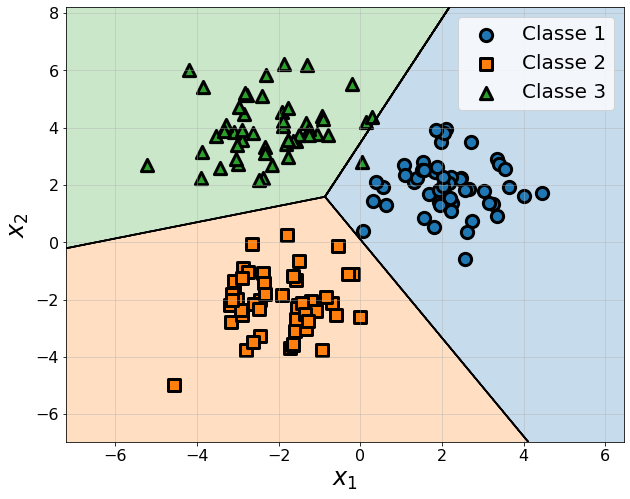

In [71]:
classes = list(set([classe for classe in y5]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

Z5_LDA = Z5_LDA.reshape(xx5.shape)
plt.contourf(xx5, yy5, Z5_LDA, cmap=CMAP3, alpha=0.25)
plt.contour(xx5, yy5, Z5_LDA, colors='black')

# Z5_QDA = Z5_QDA.reshape(xx5.shape)
# plt.contourf(xx5, yy5, Z5_QDA, cmap=CMAP3, alpha=0.25)
# plt.contour(xx5, yy5, Z5_QDA, colors='black')

for classe in classes:
    plt.scatter(X5[y5 == classe][:, 0], 
                X5[y5 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150,  
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

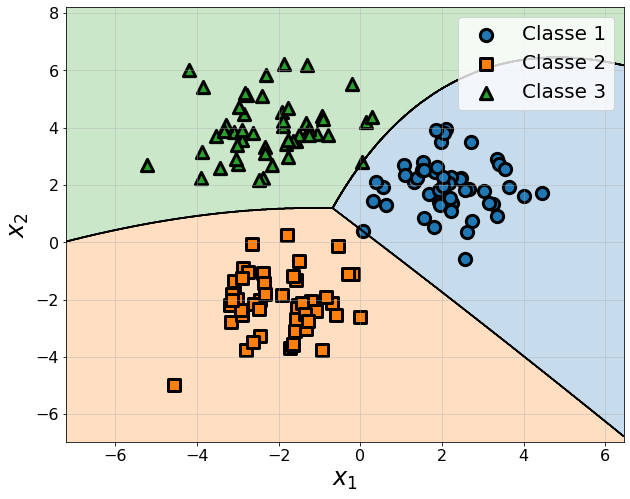

In [72]:
classes = list(set([classe for classe in y5]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

# Z5_LDA = Z5_LDA.reshape(xx5.shape)
# plt.contourf(xx5, yy5, Z5_LDA, cmap=CMAP3, alpha=0.25)
# plt.contour(xx5, yy5, Z5_LDA, colors='black')

Z5_QDA = Z5_QDA.reshape(xx5.shape)
plt.contourf(xx5, yy5, Z5_QDA, cmap=CMAP3, alpha=0.25)
plt.contour(xx5, yy5, Z5_QDA, colors='black')

for classe in classes:
    plt.scatter(X5[y5 == classe][:, 0], 
                X5[y5 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150, 
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

**Classificador mais adequado**: este é um caso em que não há qualquer sobreposição. Embora não seja fácil, é possível realizar uma classificação perfeita, com zero erros, utilizando um classificador linear, portanto, o LDA já é suficiente para satisfazer o problema, mas nada impede que o QDA seja utilizado.

### Dataset 6

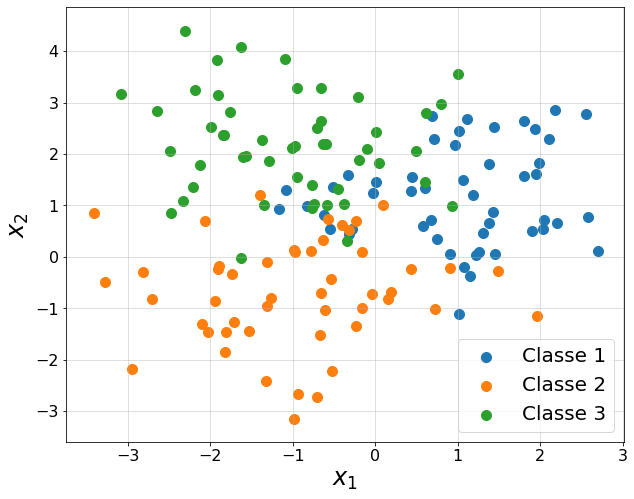

In [33]:
X6, y6 = importar_dados('datasets/dataset6.txt')
exibir_amostras(X=X6, y=y6)

In [34]:
# Bootstrap
n_repeticoes = 10

LDA_desempenho = []
QDA_desempenho = []
for execucao in range(n_repeticoes):
    
    # Holdout
    X_treino, y_treino, X_teste, y_teste = holdout(X=X6, y=y6, teste_parcela=0.30, aleatorio=True, semente=None)
    
    # LDA - Próprio
    LDA = AnaliseDiscriminante(tipo='LDA')
    LDA.treinar(X=X_treino, y=y_treino)
    LDA_y_predito = LDA.classificar(X=X_teste)
    LDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=LDA_y_predito))
    
    # QDA - Próprio
    QDA = AnaliseDiscriminante(tipo='QDA')
    QDA.treinar(X=X_treino, y=y_treino)
    QDA_y_predito = QDA.classificar(X=X_teste)
    QDA_desempenho.append(avaliar_desempenho(y_verdadeiro=y_teste, y_obtido=QDA_y_predito))

LDA_desempenho = np.array(LDA_desempenho)
LDA_desempenho_media = np.mean(LDA_desempenho)
LDA_desempenho_std = np.std(LDA_desempenho)

QDA_desempenho = np.array(QDA_desempenho)
QDA_desempenho_media = np.mean(QDA_desempenho)
QDA_desempenho_std = np.std(QDA_desempenho)


print('DATASET 1')
print('------ Acurácias -----')
print('LDA: {0:3.4f}'.format(LDA_desempenho_media))
print('QDA: {0:3.4f}'.format(QDA_desempenho_media))

DATASET 1
------ Acurácias -----
LDA: 0.8044
QDA: 0.8089


In [35]:
x_min6, x_max6 = X6[:, 0].min() - 2, X6[:, 0].max() + 2
y_min6, y_max6 = X6[:, 1].min() - 2, X6[:, 1].max() + 2
h = 0.01
xx6, yy6 = np.meshgrid(np.arange(x_min6, x_max6, h),
                     np.arange(y_min6, y_max6, h))

Z6_LDA = LDA.classificar(np.c_[xx6.ravel(), yy6.ravel()])
Z6_QDA = QDA.classificar(np.c_[xx6.ravel(), yy6.ravel()])

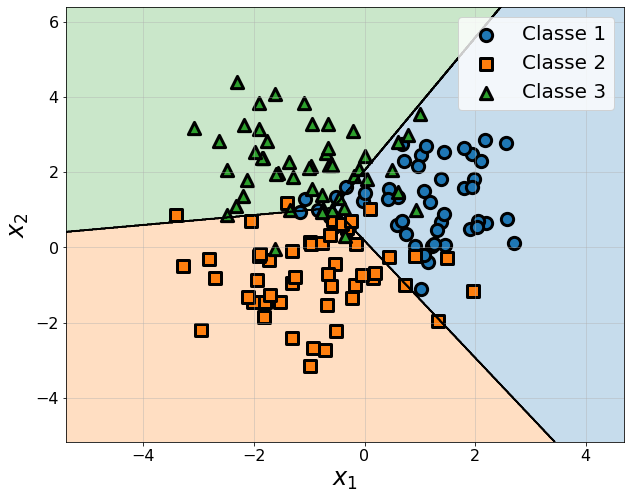

In [73]:
classes = list(set([classe for classe in y6]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

Z6_LDA = Z6_LDA.reshape(xx6.shape)
plt.contourf(xx6, yy6, Z6_LDA, cmap=CMAP3, alpha=0.25)
plt.contour(xx6, yy6, Z6_LDA, colors='black')

# Z6_QDA = Z6_QDA.reshape(xx6.shape)
# plt.contourf(xx6, yy6, Z6_QDA, cmap=CMAP3, alpha=0.25)
# plt.contour(xx6, yy6, Z6_QDA, colors='black')

for classe in classes:
    plt.scatter(X6[y6 == classe][:, 0], 
                X6[y6 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150,  
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

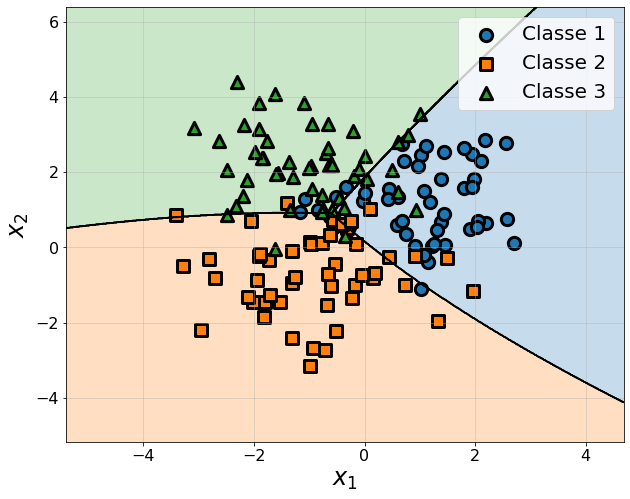

In [74]:
classes = list(set([classe for classe in y6]))
n_classes = len(classes)

plt.figure(figsize=(10, 8))

# Z6_LDA = Z6_LDA.reshape(xx6.shape)
# plt.contourf(xx6, yy6, Z6_LDA, cmap=CMAP3, alpha=0.25)
# plt.contour(xx6, yy6, Z6_LDA, colors='black')

Z6_QDA = Z6_QDA.reshape(xx6.shape)
plt.contourf(xx6, yy6, Z6_QDA, cmap=CMAP3, alpha=0.25)
plt.contour(xx6, yy6, Z6_QDA, colors='black')

for classe in classes:
    plt.scatter(X6[y6 == classe][:, 0], 
                X6[y6 == classe][:, 1], 
                edgecolors='black', 
                marker=MARKERS[classe-1],
                s=150, 
                linewidth=3, 
                label='Classe ' + str(classe))

plt.legend(fontsize=20)
plt.grid(True, linestyle='-', alpha=0.5)

plt.xlabel(r'$x_{1}$', fontsize=24)
plt.ylabel(r'$x_{2}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

**Classificador mais adequado**: neste caso há sobreposição, o que não permite uma classificação completamente isenta de erros, mas um bom desempenho pode ser alcançado por ambos os classificadores, sem que haja grandes diferenças entre eles.